# **Weather Time Series Forecasting**

## Introduction
Weather affects everything from daily decisions about what to wear to the planning of significant events. Accurate forecasting is crucial for safety, agriculture, aviation, and disaster preparedness. But how do we predict what nature has in store?

## The Role of Machine Learning
Traditional weather forecasting relies on complex physics-based models to simulate atmospheric conditions. While these models are effective, they can be slow and sometimes lack the precision needed for local predictions. Enter machine learning: by analyzing vast amounts of weather data, it can detect patterns that even the most sophisticated traditional models might miss, allowing for more accurate and localized forecasts.

## Time Series Forecasting
Time series forecasting, a key machine learning technique, uses historical data to predict future events. By examining past weather patterns, it helps anticipate changes in temperature, wind, and other variables. This method transforms vast amounts of historical data into insights about future conditions, making it an invaluable tool for meteorologists and data scientists alike.

## Project Overview
In this project, we dive deep into weather data from May 2023 to July 2024, focusing on daily temperature highs and lows across nine major cities. Using Ridge regression, a robust machine learning algorithm, we aim to predict future temperatures and uncover the key factors influencing these changes.

Join me on this exploration of weather patterns as we use data science to decode the natural world. By the end of this journey, we will have not only predicted the weather but also deepened our understanding of the forces shaping our environment.

**Let's begin**.

<div class="alert alert-block alert-info">
<b>Data Limitations:</b> The data collected is limited to about a year of weather and 9 locations
</div>

## **Import Libraries and Data**
Before we dive into the data, we need to gather our tools. In data science, this means importing the necessary libraries and loading our dataset. These libraries streamline complex tasks, making data manipulation, analysis, and visualization much more manageable.

**Why These Libraries?**
- **Pandas**: A powerful library for managing and manipulating large datasets efficiently.
- **Statsmodels and Scikit-Learn**: Our primary libraries for statistical analysis and machine learning, providing robust tools for building and evaluating forecasting models.
- **Matplotlib and Seaborn**: Essential for data visualization, these libraries help us quickly identify trends and patterns within our data.

In [1277]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Statistical Analysis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

# Machine Learning
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge

# Define seaborn color palette for plots
color_pal = sns.color_palette()

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv("Weather_data_2023_2024.csv")

# Ensure the 'datetime' column is parsed as datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Set a multi-level index with 'location' and 'datetime'
df.set_index(['location', 'datetime'], inplace=True)


## **Data Exploration**
### Building a Strong Foundation for Accurate Forecasting
Data exploration is a crucial step in understanding the characteristics and patterns of our dataset. It allows us to identify potential issues and prepare our data for modeling. In this phase, we will:

- **Identify Trends and Seasonality**: Examine the data to uncover recurring patterns and seasonal variations that are critical for time series forecasting.
- **Detect Outliers and Handle Missing Values**: Ensure data quality by identifying anomalies and filling gaps, preventing skewed results and inaccuracies in our models.
- **Assess Feature Relationships**: Analyze correlations among variables to understand dependencies and inform feature selection, ensuring that we include the most predictive attributes.

A thorough exploration lays the groundwork for building reliable and accurate forecasting models by ensuring that our data is clean, consistent, and insightful.

### Visualizing Temperature Trends
To get an initial understanding of our target variables, tempmax and tempmin, we plot them over time to observe their distribution and any evident patterns.

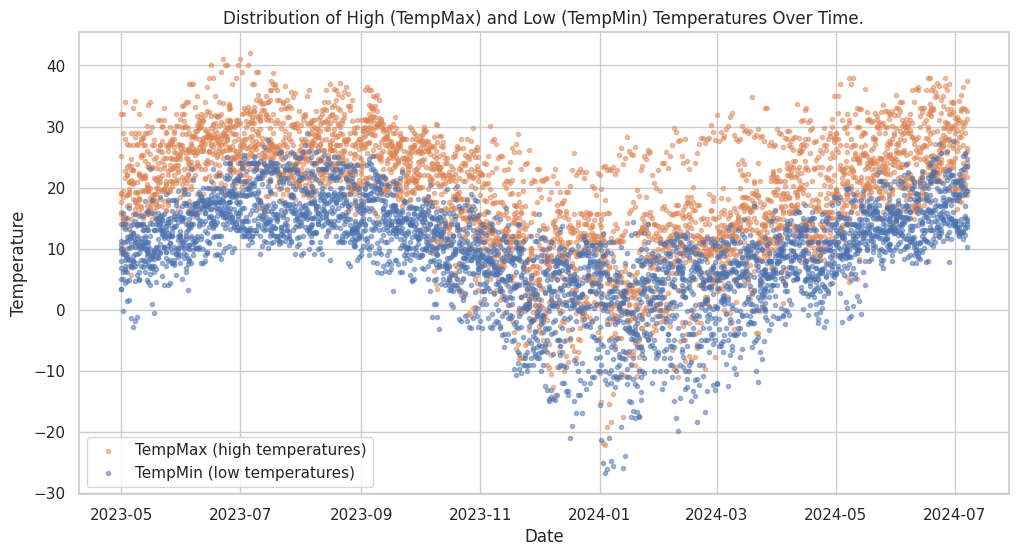

In [1278]:
# Plot tempmax and tempmin (target variables) to get an idea of the distribution
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(df.index.get_level_values('datetime'), df['tempmax'], color=color_pal[1], label='TempMax (high temperatures)', alpha=0.5, marker='.')
plt.scatter(df.index.get_level_values('datetime'), df['tempmin'], color=color_pal[0], label='TempMin (low temperatures)', alpha=0.5, marker='.')

# Add titles and labels
plt.title('Distribution of High (TempMax) and Low (TempMin) Temperatures Over Time.')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Initial Data Inspection
We begin by inspecting the dataset to check for any initial issues such as duplicate entries or missing values.

In [1279]:
# Display the first few rows of the dataframe
df.head()

tempmax  tempmin  temp  feelslikemax  feelslikemin  \
location datetime                                                         
Beijing  2023-05-01     25.2      8.0  18.1          25.2           8.0   
         2023-05-02     29.0     15.8  22.3          27.9          15.8   
         2023-05-03     28.0     14.0  21.2          27.6          14.0   
         2023-05-04     22.0     15.0  17.8          22.0          15.0   
         2023-05-05     19.0     16.7  17.8          19.0          16.7   

                     feelslike   dew  humidity  precip  precipprob  ...  \
location datetime                                                   ...   
Beijing  2023-05-01       18.1   8.1      54.7     0.0           0  ...   
         2023-05-02       22.1  10.4      48.9     0.0           0  ...   
         2023-05-03       21.1  12.4      59.4     0.0           0  ...   
         2023-05-04       17.8  14.0      79.1     0.1         100  ...   
         2023-05-05       17.8   9.5      61.9     1.1         100  ...   

                     sealevelpressure  cloudcover  visibility  \
location datetime                                               
Beijing  2023-05-01            1009.6        54.2        10.4   
         2023-05-02            1008.3        26.0        10.6   
         2023-05-03            1011.3        62.2        10.1   
         2023-05-04            1009.2        85.1         8.4   
         2023-05-05            1009.1        95.8        11.4   

                                 sunrise               sunset  moonphase  \
location datetime                                                          
Beijing  2023-05-01  2023-05-01T05:15:37  2023-05-01T19:08:22       0.35   
         2023-05-02  2023-05-02T05:14:22  2023-05-02T19:09:22       0.39   
         2023-05-03  2023-05-03T05:13:08  2023-05-03T19:10:22       0.42   
         2023-05-04  2023-05-04T05:11:56  2023-05-04T19:11:22       0.45   
         2023-05-05  2023-05-05T05:10:45  2023-05-05T19:12:22       0.48   

                                 conditions  \
location datetime                             
Beijing  2023-05-01        Partially cloudy   
         2023-05-02        Partially cloudy   
         2023-05-03        Partially cloudy   
         2023-05-04  Rain, Partially cloudy   
         2023-05-05          Rain, Overcast   

                                                           description  \
location datetime                                                        
Beijing  2023-05-01                  Partly cloudy throughout the day.   
         2023-05-02                  Partly cloudy throughout the day.   
         2023-05-03                  Partly cloudy throughout the day.   
         2023-05-04  Partly cloudy throughout the day with late aft...   
         2023-05-05  Cloudy skies throughout the day with rain clea...   

                                  icon          stations  
location datetime                                         
Beijing  2023-05-01  partly-cloudy-day  ZBAA,54511099999  
         2023-05-02  partly-cloudy-day  ZBAA,54511099999  
         2023-05-03  partly-cloudy-day  ZBAA,54511099999  
         2023-05-04               rain  ZBAA,54511099999  
         2023-05-05               rain  ZBAA,54511099999  

[5 rows x 26 columns]

In [1280]:
# Display all locations in multiindex
df.index.get_level_values('location').value_counts()

location
Beijing          434
Berlin           434
London           434
Mexico City      434
Moscow           434
Ottawa           434
Paris            434
Rome             434
Washington DC    434
Name: count, dtype: int64

In [1200]:
# Check data types of each column
df.dtypes

tempmax             float64
tempmin             float64
temp                float64
feelslikemax        float64
feelslikemin        float64
feelslike           float64
dew                 float64
humidity            float64
precip              float64
precipprob            int64
precipcover         float64
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
sunrise              object
sunset               object
moonphase           float64
conditions           object
description          object
icon                 object
stations             object
dtype: object

In [1201]:
# Check for duplicate values in data
df.duplicated().sum()

0

In [1202]:
# Display missing values
df.isnull().sum()

tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

### Data Cleaning
Based on our initial inspection, we proceed with cleaning the dataset:

In [1203]:
# Drop Columns of no interest
df = df.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

# Display updated dataframe
df.head()

tempmax  tempmin  temp  feelslikemax  feelslikemin  \
location datetime                                                         
Beijing  2023-05-01     25.2      8.0  18.1          25.2           8.0   
         2023-05-02     29.0     15.8  22.3          27.9          15.8   
         2023-05-03     28.0     14.0  21.2          27.6          14.0   
         2023-05-04     22.0     15.0  17.8          22.0          15.0   
         2023-05-05     19.0     16.7  17.8          19.0          16.7   

                     feelslike   dew  humidity  precip  precipprob  \
location datetime                                                    
Beijing  2023-05-01       18.1   8.1      54.7     0.0           0   
         2023-05-02       22.1  10.4      48.9     0.0           0   
         2023-05-03       21.1  12.4      59.4     0.0           0   
         2023-05-04       17.8  14.0      79.1     0.1         100   
         2023-05-05       17.8   9.5      61.9     1.1         100   

                     precipcover  snow  snowdepth  windgust  windspeed  \
location datetime                                                        
Beijing  2023-05-01         0.00   0.0        0.0      36.4       21.6   
         2023-05-02         0.00   0.0        0.0      37.4       21.6   
         2023-05-03         0.00   0.0        0.0      30.6       18.0   
         2023-05-04         4.17   0.0        0.0      28.8       14.4   
         2023-05-05         8.33   0.0        0.0      46.8       28.8   

                     winddir  sealevelpressure  cloudcover  visibility  \
location datetime                                                        
Beijing  2023-05-01    110.5            1009.6        54.2        10.4   
         2023-05-02    133.7            1008.3        26.0        10.6   
         2023-05-03    122.7            1011.3        62.2        10.1   
         2023-05-04     99.7            1009.2        85.1         8.4   
         2023-05-05      5.6            1009.1        95.8        11.4   

                     moonphase  
location datetime               
Beijing  2023-05-01       0.35  
         2023-05-02       0.39  
         2023-05-03       0.42  
         2023-05-04       0.45  
         2023-05-05       0.48

### Analysis of Temperature Trends

The following plots display the distribution of maximum and minimum temperatures over time for selected cities. The `TempMax` and `TempMin` plots reveal the variations in temperatures, showcasing which cities experience the highest and lowest temperatures. 

Additionally, seasonal decomposition can be applied to gain insights into the underlying seasonal patterns and trends.


In [1388]:
# Define temperature thresholds
hot_threshold = 30.0
cold_threshold = 0.0

# Filter DataFrame for rows where tempmax > hot_threshold
hot_counts = df[df['tempmax'] > hot_threshold].groupby('location').size().sort_values(ascending=False)

# Filter DataFrame for rows where tempmin < cold_threshold
cold_counts = df[df['tempmin'] < cold_threshold].groupby('location').size().sort_values(ascending=False)

# Display the results
print("Number of days with TempMax > 30.0°C for each city:")
print(hot_counts)

print("\nNumber of days with TempMin < 0.0°C for each city:")
print(cold_counts)


Number of days with TempMax > 30.0°C for each city:
location
Beijing          117
Washington DC     88
Mexico City       80
Rome              74
Paris             20
Berlin            11
Ottawa            11
London             7
Moscow             7
dtype: int64

Number of days with TempMin < 0.0°C for each city:
location
Moscow           147
Ottawa           131
Beijing          124
Berlin            37
Washington DC     26
Paris             16
London             8
Mexico City        6
dtype: int64


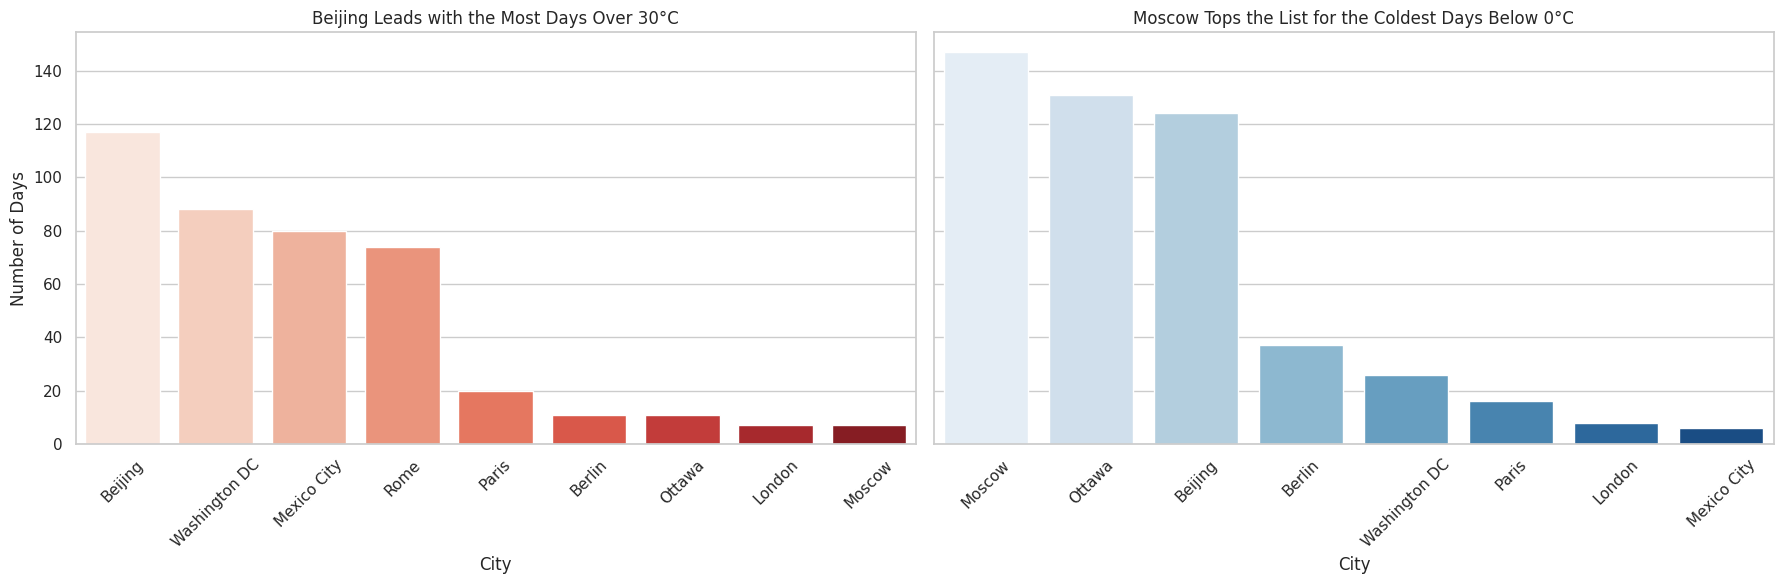

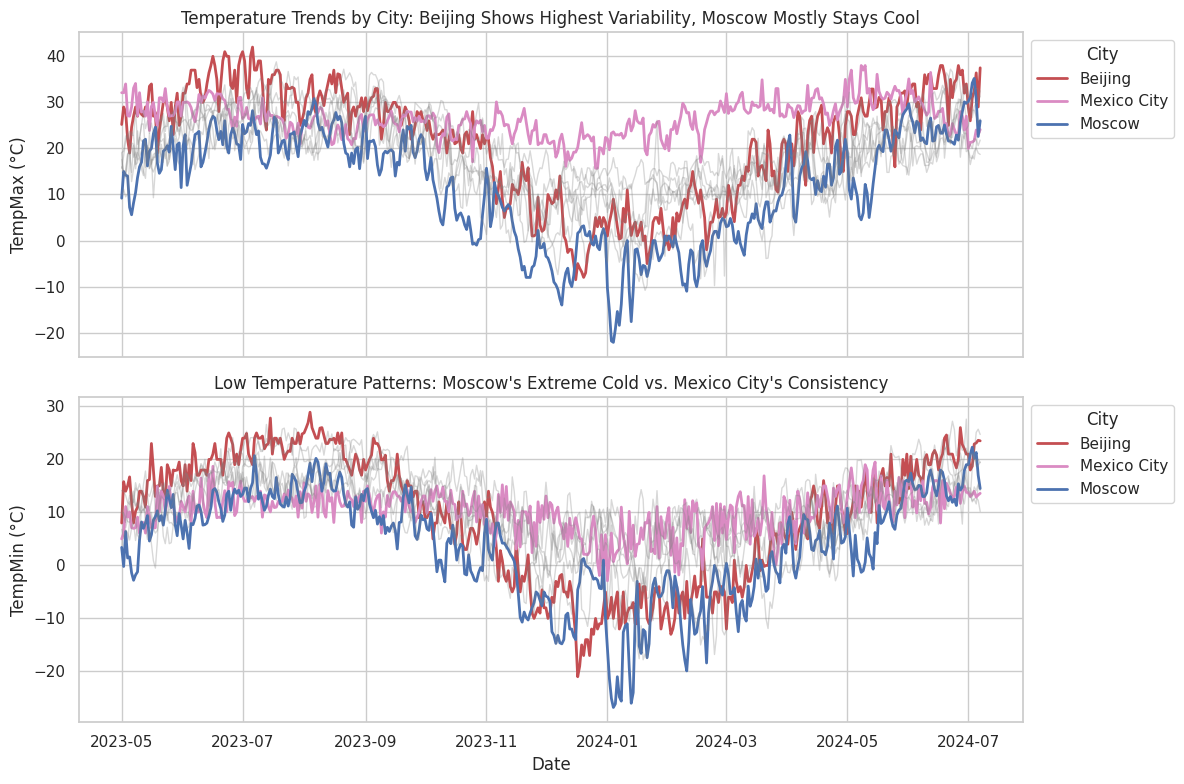

In [1458]:
# List of cities to highlight for TempMax and TempMin
highlight_cities = ['Beijing', 'Mexico City', 'Moscow']
all_cities = df.index.get_level_values('location').unique()

# Define colors for highlighted cities
highlight_colors = {
    'Beijing': color_pal[3],
    'Mexico City': color_pal[6],
    'Moscow': color_pal[0]
}

# Set up the subplot structure
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plotting hot days on the first subplot
sns.barplot(x=hot_counts.index, y=hot_counts.values, hue=hot_counts.index, palette="Reds", dodge=False, ax=axes[0])
axes[0].set_title('Beijing Leads with the Most Days Over 30°C')
axes[0].set_xlabel('City')
axes[0].set_ylabel('Number of Days')
axes[0].tick_params(axis='x', rotation=45)

# Plotting cold days on the second subplot
sns.barplot(x=cold_counts.index, y=cold_counts.values, hue=cold_counts.index, palette="Blues", dodge=False, ax=axes[1])
axes[1].set_title('Moscow Tops the List for the Coldest Days Below 0°C')
axes[1].set_xlabel('City')
axes[1].set_ylabel('Number of Days')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Plot temperature distributions
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot for TempMax
for city in all_cities:
    city_data = df.xs(city, level='location').reset_index()
    if city in highlight_cities:
        sns.lineplot(data=city_data, x='datetime', y='tempmax', ax=axes[0],
                     label=city, color=highlight_colors[city], linewidth=2)
    else:
        sns.lineplot(data=city_data, x='datetime', y='tempmax', ax=axes[0],
                     color='gray', alpha=0.3, linewidth=1)
axes[0].set_title('Temperature Trends by City: Beijing Shows Highest Variability, Moscow Mostly Stays Cool')
axes[0].set_ylabel('TempMax (°C)')
axes[0].legend(title='City', bbox_to_anchor=(1, 1), loc='upper left')

# Plot for TempMin
for city in all_cities:
    city_data = df.xs(city, level='location').reset_index()
    if city in highlight_cities:
        sns.lineplot(data=city_data, x='datetime', y='tempmin', ax=axes[1],
                     label=city, color=highlight_colors[city], linewidth=2)
    else:
        sns.lineplot(data=city_data, x='datetime', y='tempmin', ax=axes[1],
                     color='gray', alpha=0.3, linewidth=1)
axes[1].set_title("Low Temperature Patterns: Moscow's Extreme Cold vs. Mexico City's Consistency")
axes[1].set_ylabel('TempMin (°C)')
axes[1].set_xlabel('Date')
axes[1].legend(title='City', bbox_to_anchor=(1, 1), loc='upper left')

# Adjust the layout
plt.tight_layout()
plt.show()



**Conclusions**:

**Hot Days (TempMax > 30.0°C)**: 
- Beijing experiences the most hot days (117), followed by Washington DC (88) and Mexico City (80). 
- European cities like Paris, Berlin, and London have significantly fewer hot days, with Moscow and London having the least (7 days each).

**Cold Days (TempMin < 0.0°C)**: 
- Moscow sees the highest number of cold days (147), indicating its colder climate, followed by Ottawa (131) and Beijing (124).
- Warmer climates like Mexico City experience almost no days below freezing (6 days).

### Correlation Analysis
Next, we analyze feature correlations to understand the relationships between variables, which can help identify multicollinearity or inform feature selection.

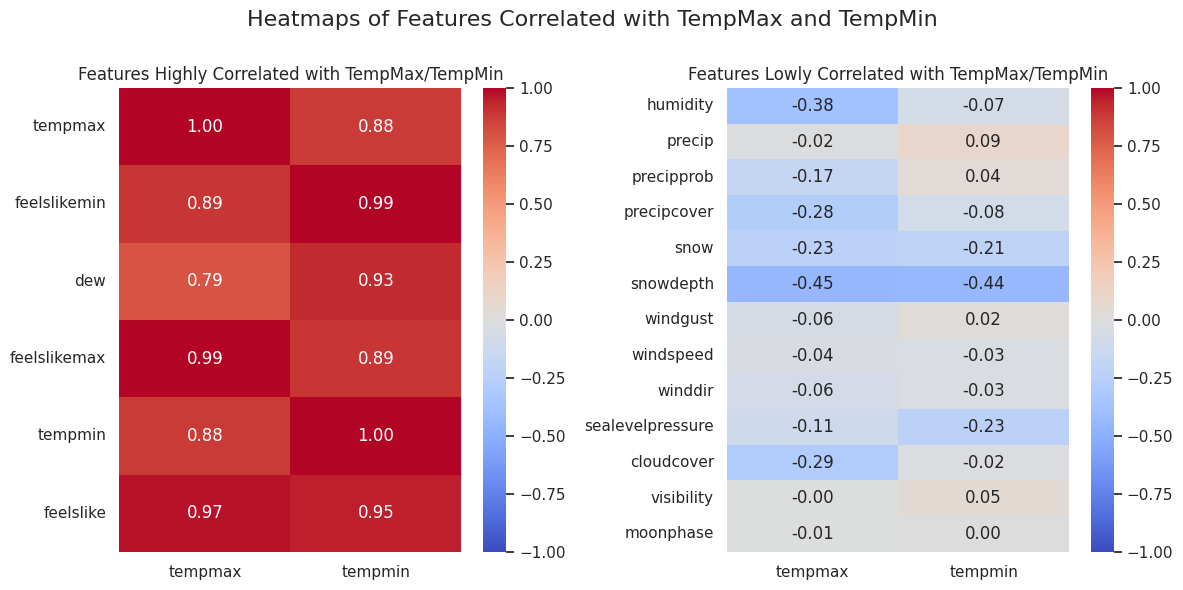

In [1261]:
# Select numerical features that might indicate multicollinearity
all_features = df[['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip',
                   'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
                   'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

# Compute the correlation matrix
correlation_matrix = all_features.corr()

# Set the threshold for high and low correlation
threshold = 0.75

# Filter for features above the threshold (correlation with target variables)
high_corr_max = correlation_matrix.loc['tempmax'][(correlation_matrix.loc['tempmax'] >= threshold) | (correlation_matrix.loc['tempmax'] <= -threshold)]
high_corr_min = correlation_matrix.loc['tempmin'][(correlation_matrix.loc['tempmin'] >= threshold) | (correlation_matrix.loc['tempmin'] <= -threshold)]

# Combine the above-threshold features
high_corr_features = list(set(high_corr_max.index.tolist() + high_corr_min.index.tolist()))

# Create a new correlation matrix for high correlation features
high_correlation_matrix = correlation_matrix.loc[high_corr_features, ['tempmax', 'tempmin']]

# Create a new correlation matrix for low correlation features (excluding those above the threshold)
low_correlation_matrix = correlation_matrix.drop(high_corr_features).loc[:, ['tempmax', 'tempmin']]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the heatmap for features with high correlations against the target variables
sns.heatmap(high_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Features Highly Correlated with TempMax/TempMin")

# Plot the heatmap for features with low correlations against the target variables
sns.heatmap(low_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Features Lowly Correlated with TempMax/TempMin")

# Add a main title for the entire figure
fig.suptitle("Heatmaps of Features Correlated with TempMax and TempMin", fontsize=16)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust top to make room for the suptitle
plt.show()


### Statistical Summary
Analyzing the central tendency, symmetry, and variability of our dataset provides insights into its distribution and potential impacts on model performance.

In [1205]:
# Display summary statistics
display(df.describe())

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase
count,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000
mean,18.955402,9.414849,14.202330,18.499795,8.157168,13.398541,7.346467,67.568152,1.929340,48.888121,10.350663,0.087839,1.556759,35.276165,21.005428,191.912801,1014.354916,58.267588,16.540374,0.487063
std,9.830447,8.251788,8.749541,10.906910,9.876715,10.188162,8.307355,15.369026,5.591233,49.747341,16.836617,0.816638,7.414970,13.533089,7.653159,100.153515,8.854499,27.783827,8.760752,0.288540
min,-22.100000,-26.800000,-24.900000,-30.900000,-35.400000,-33.100000,-27.900000,10.100000,0.000000,0.000000,0.000000,0.000000,0.000000,5.400000,4.300000,0.000000,966.700000,0.000000,2.600000,0.000000
25%,12.500000,5.100000,9.200000,12.500000,3.000000,7.900000,3.225000,58.100000,0.000000,0.000000,0.000000,0.000000,0.000000,25.900000,15.900000,112.900000,1009.600000,38.000000,10.000000,0.250000
50%,20.600000,10.500000,15.800000,20.600000,10.500000,15.800000,8.800000,69.600000,0.000000,0.000000,0.000000,0.000000,0.000000,34.200000,20.100000,203.400000,1014.800000,61.850000,14.100000,0.500000
75%,26.400000,15.000000,20.200000,26.300000,15.000000,20.200000,13.000000,79.100000,1.059000,100.000000,12.500000,0.000000,0.000000,43.200000,24.900000,271.700000,1019.575000,81.900000,21.200000,0.750000
max,42.000000,28.900000,33.000000,46.000000,36.700000,40.800000,27.700000,99.500000,134.000000,100.000000,100.000000,24.800000,62.200000,175.700000,178.500000,359.900000,1044.300000,100.000000,49.600000,0.980000


### Findings:
- **No duplicate values**: Ensures data integrity and reliability for modeling.
- **Missing values are minimal**: The affected columns can be dropped without significant data loss.
- **High correlation among features**: Particularly among temperature and feels-like metrics, indicating potential multicollinearity that needs addressing.
- **Varied distribution patterns**: Features like precipitation and snow are sporadic but significant when they occur, suggesting the need for potential transformations.
- **Dynamic features**: Variability in features like wind direction and pressure suggests they could be crucial for model accuracy.
### Actions:
- **Drop irrelevant columns** to focus on more pertinent features.
- **Address multicollinearity** by removing or combining highly correlated features.
- **Transform skewed features** like precipitation and snow to normalize their distributions.
- **Consider feature engineering** on dynamic features to enhance their predictive power.


## **Next, Feature Selection and Engineering**
**Objective**:
To enhance the predictive performance of the model by addressing multicollinearity, capturing temporal dependencies, and ensuring the stability of the feature set.

### Initial Feature Assessment
**Purpose**: To identify multicollinearity among features, which can affect model performance.
- Conducted Variance Inflation Factor (VIF) analysis to identify highly correlated features

**Key Findings**: 
Significant multicollinearity was present, especially in temperature-related and humidity features e.g., VIF `feelslike` was **512.31**, and for `humidity`, it was **357.71**. (VIF > 10 indicates significant multicollinearity)

In [1206]:
# Drop target variables to conduct VIF test
all_features = all_features.drop(['tempmax', 'tempmin'], axis=1)

# Calculate VIF for each feature in tempmax
vif_data = pd.DataFrame()
vif_data["all initial features"] = all_features.columns
vif_data["VIF"] = [variance_inflation_factor(all_features.values, i) for i in range(all_features.shape[1])]

vif_data

,all initial features,VIF
0,feelslikemax,252.954949
1,feelslikemin,73.212278
2,feelslike,512.314310
3,dew,125.018260
4,humidity,357.713279
5,precip,1.578707
6,precipprob,3.837234
7,precipcover,3.380402
8,snow,1.187286
9,snowdepth,1.482063


### Feature Combination to Reduce Multicollinearity
**Approach**: Combine highly correlated features to reduce multicollinearity.
- Created new combined features, such as `feelslike_max_combined` and `dew_humidity`, to represent the average of correlated features.
- This step helped reduce the VIF scores significantly, improving model stability.

In [1207]:
# Combine features of significant importance for multicollinearity
df['feelslike_max_combined'] = df[['feelslikemax', 'feelslike']].mean(axis=1)
df['feelslike_min_combined'] = df[['feelslikemin', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

combined_features = df[['feelslike_max_combined', 'feelslike_min_combined', 'dew_humidity']]
display(combined_features)


feelslike_max_combined  feelslike_min_combined  \
location      datetime                                                     
Beijing       2023-05-01                   21.65                   13.05   
              2023-05-02                   25.00                   18.95   
              2023-05-03                   24.35                   17.55   
              2023-05-04                   19.90                   16.40   
              2023-05-05                   18.40                   17.25   
...                                          ...                     ...   
Washington DC 2024-07-03                   27.55                   21.90   
              2024-07-04                   32.50                   24.95   
              2024-07-05                   36.10                   28.75   
              2024-07-06                   36.90                   29.30   
              2024-07-07                   32.05                   27.20   

                          dew_humidity  
location      datetime                  
Beijing       2023-05-01         31.40  
              2023-05-02         29.65  
              2023-05-03         35.90  
              2023-05-04         46.55  
              2023-05-05         35.70  
...                                ...  
Washington DC 2024-07-03         38.05  
              2024-07-04         45.15  
              2024-07-05         51.20  
              2024-07-06         52.40  
              2024-07-07         48.50  

[3906 rows x 3 columns]

### Addressing Autocorrelation
**Objective**: Introduce lagged variables to capture temporal dependencies and improve model performance.
- **Process**: Added lagged variables for key features based on autocorrelation analysis.
- **Implementation**: Functions were created to generate lagged variables and interpolate missing values. Key lagged features like `feelslike_max_combined_lags` and `dew_humidity_lags` were used in the final model.

In [1208]:
# Function to create lagged variables
def create_lagged_variables(df, columns, lags):
    for col in columns:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Function to interpolate lagged variables
def interpolate_columns(df, columns):
    df[columns] = df[columns].interpolate()
    return df

# Define columns and lags
tempmax_columns = ['feelslike_max_combined']
tempmin_columns = ['dew_humidity', 'snow']
short_lags = [1]
all_lags = [1, 4, 7, 19]

# Create lagged variables
df = create_lagged_variables(df, tempmax_columns, short_lags)
df = create_lagged_variables(df, tempmin_columns, all_lags)

# Interpolate lagged variables
lagged_columns = [f'{col}_lag{lag}' for col in tempmax_columns for lag in short_lags] + \
                 [f'{col}_lag{lag}' for col in tempmin_columns for lag in all_lags]
df = interpolate_columns(df, lagged_columns)

# Drop any remaining null values in df
df = df.dropna()

# Combine most important lagged values by taking the mean
df['feelslike_max_combined_lags'] = df[['feelslike_max_combined', 'feelslike_max_combined_lag1']].mean(axis=1)
df['dew_humidity_lags'] = df[[f'dew_humidity_lag{lag}' for lag in all_lags]].mean(axis=1)
df['snow_lags'] = df[['snow', 'snow_lag1']].mean(axis=1)

# Recalculate the features DataFrame with lagged variables for tempmax
features_combined_max = df[['feelslike_max_combined_lags', 'dew_humidity', 'snow', 'windgust']]

# Recalculate the features DataFrame with lagged variables for tempmin
features_combined_min = df[['feelslike_min_combined', 'dew_humidity_lags', 'snow_lags', 'precipcover']]


### Reevaluate VIF After Feature Engineering
**Objective**: Recalculate VIF to ensure that the engineered features reduced multicollinearity effectively.

**Results**: The recalculated VIF scores showed a significant reduction, confirming the effectiveness of combining features and adding lagged variables.

In [1236]:
# Calculate VIF for each feature in tempmax
vif_data_max = pd.DataFrame()
vif_data_max["tempmax feature"] = features_combined_max.columns
vif_data_max["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Calculate VIF for each feature in tempmin
vif_data_min = pd.DataFrame()
vif_data_min["tempmin feature"] = features_combined_min.columns
vif_data_min["VIF"] = [variance_inflation_factor(features_combined_min.values, i) for i in range(features_combined_min.shape[1])]

# Display vif dataframe
display(vif_data_max)
display(vif_data_min)

,tempmax feature,VIF
0,feelslike_max_combined_lags,3.444812
1,dew_humidity,7.068308
2,snow,1.082608
3,windgust,5.488185


,tempmin feature,VIF
0,feelslike_min_combined,2.566945
1,dew_humidity_lags,3.231614
2,snow_lags,1.162367
3,precipcover,1.542622


### Summary of Actions Taken
- **High Multicollinearity**: Identified and addressed by combining correlated features.
- **Feature Combination**: Reduced multicollinearity with new features like `feelslike_max_combined` and `dew_humidity`.
- **Lagged Variables**: Introduced to capture temporal patterns and address autocorrelation.
- **VIF Reassessment**: Confirmed reduced multicollinearity in the new feature set.

### Visual Analysis
- **Correlation Heatmaps**: Displayed for TempMax and TempMin features, highlighting relationships and effectiveness of feature engineering.
- **VIF Bar Plots**: Visual representation of VIF scores for TempMax and TempMin features after feature engineering.

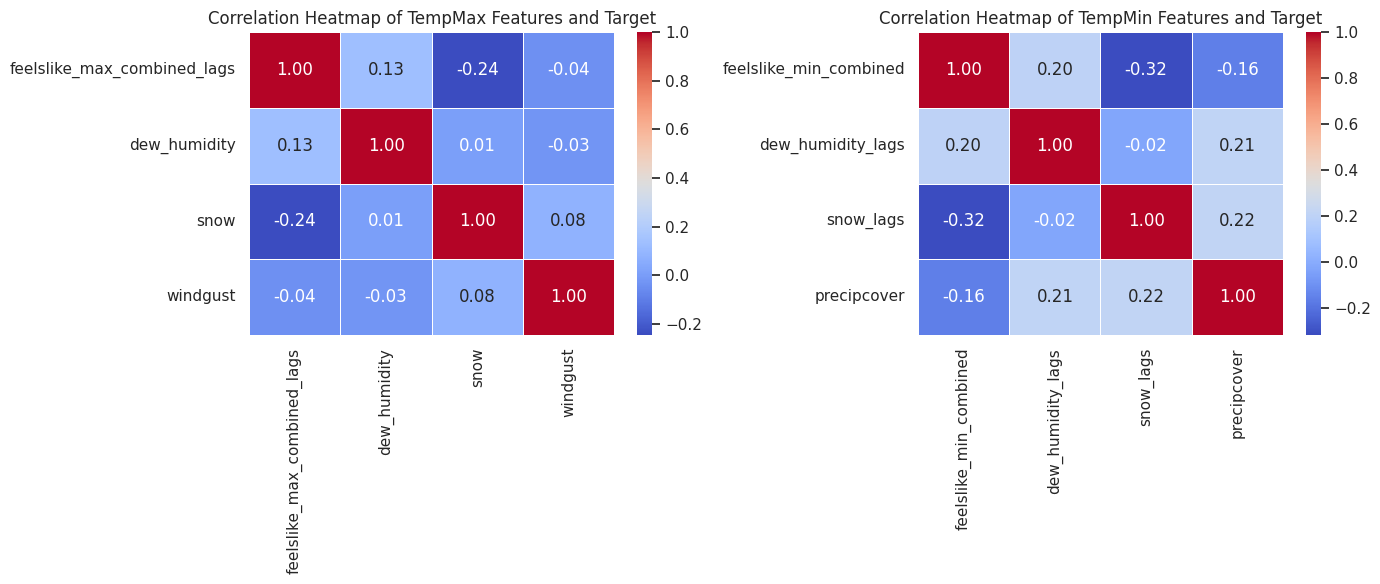

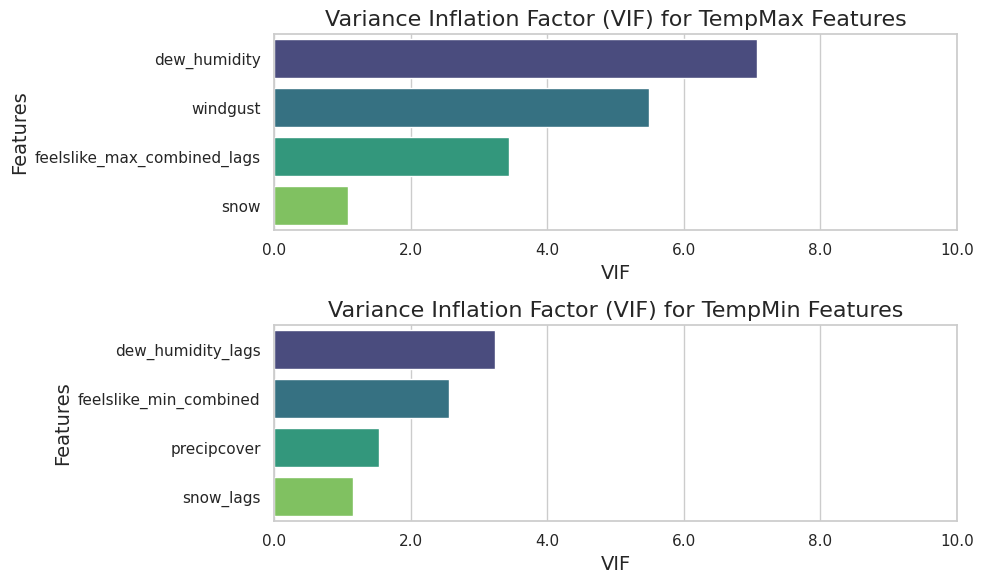

In [1237]:
# Get correlation of tempmax and tempmin features
matrix_max = features_combined_max.corr()
matrix_min = features_combined_min.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot heatmap for TempMax
sns.heatmap(matrix_max, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap of TempMax Features and Target')

# Plot heatmap for TempMin
sns.heatmap(matrix_min, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap of TempMin Features and Target')

plt.tight_layout()
plt.show()

# Plotting the VIF results for tempmax and tempmin as subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
sns.set(style="whitegrid")

# VIF for TempMax Features
sns.barplot(x="VIF", y="tempmax feature", hue="tempmax feature", dodge=False, data=vif_data_max.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[0], legend=False)
axes[0].set_title('Variance Inflation Factor (VIF) for TempMax Features', fontsize=16)
axes[0].set_xlabel('VIF', fontsize=14)
axes[0].set_ylabel('Features', fontsize=14)
axes[0].set_xlim(0, 10)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# VIF for TempMin Features
sns.barplot(x="VIF", y="tempmin feature", hue="tempmin feature", dodge=False, data=vif_data_min.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[1], legend=False)
axes[1].set_title('Variance Inflation Factor (VIF) for TempMin Features', fontsize=16)
axes[1].set_xlabel('VIF', fontsize=14)
axes[1].set_ylabel('Features', fontsize=14)
axes[1].set_xlim(0, 10)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Adjust layout
plt.tight_layout()
plt.show()

## **Data Splitting** - Train/Validate/Test
Effective data splitting is crucial in time series analysis to maintain temporal sequence, prevent data leakage, and ensure unbiased model evaluation. The approach used ensures the model generalizes well and reflects real-world performance.

For this project, we’ve divided the data as follows:
- **Training Set (~70%)**: Used to fit the model, where it learns patterns, relationships, and trends to form the foundation of its predictions.
- **Validation Set (~10%)**: Used to fine-tune the model, aiding in model selection, feature selection, and hyperparameter tuning.
- **Test Set (~20%)**: Provides an unbiased assessment of the model’s performance on unseen data.

In [1212]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

In [1213]:
# Split the data into training, validation, and testing sets
train = df.loc[df.index.get_level_values('datetime') < train_end_date]
validate = df.loc[(df.index.get_level_values('datetime') >= train_end_date) & (df.index.get_level_values('datetime') < validate_end_date)]
test = df.loc[df.index.get_level_values('datetime') >= test_start_date]

### Visualize the Splits
To visualize the splits, scatter plots of temperatures were created:

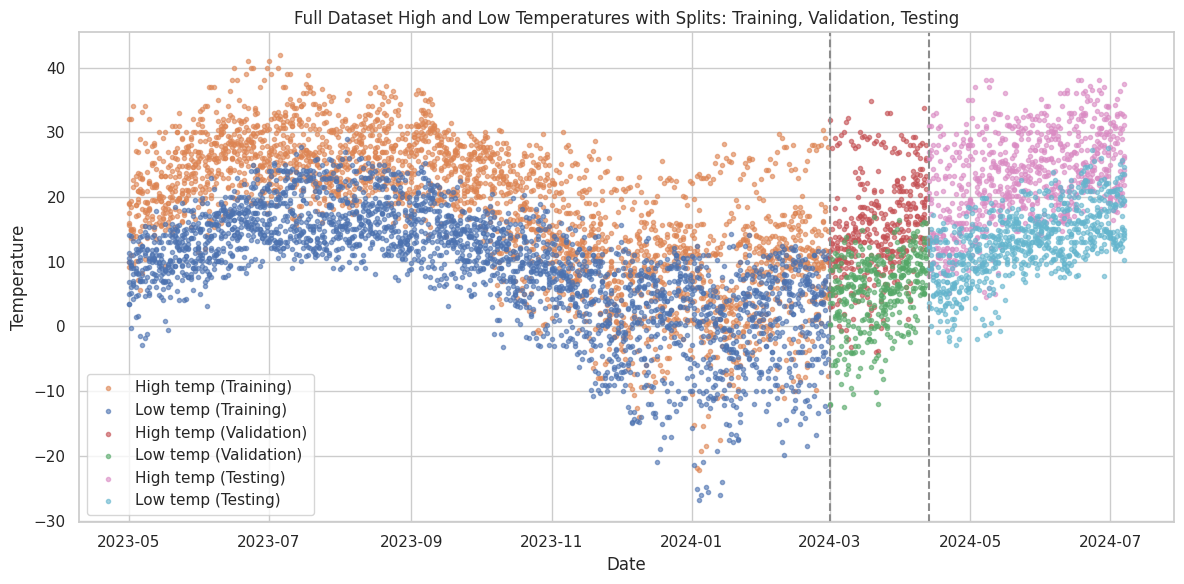

In [1240]:
# Create scatter plots to visualize splits
fig, ax = plt.subplots(figsize=(12, 6))

# Plot temperatures for each dataset: train, validate, test
for dataset, color, label_max, label_min in zip([train, validate, test],
                                                [(color_pal[1], color_pal[0]),
                                                 (color_pal[3], color_pal[2]),
                                                 (color_pal[6], color_pal[9])],
                                                ['High temp (Training)', 'High temp (Validation)', 'High temp (Testing)'],
                                                ['Low temp (Training)', 'Low temp (Validation)', 'Low temp (Testing)']):
    plt.scatter(dataset.index.get_level_values('datetime'), dataset['tempmax'], color=color[0], label=label_max, alpha=0.6, marker='.')
    plt.scatter(dataset.index.get_level_values('datetime'), dataset['tempmin'], color=color[1], label=label_min, alpha=0.6, marker='.')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[7], ls='--')
ax.axvline(validate_end_date, color=color_pal[7], ls='--')

# Add titles, labels, and legend
plt.title('Full Dataset High and Low Temperatures with Splits: Training, Validation, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Define Target Variables and Feature Sets

In [1241]:
# Define target variables
y_max = df['tempmax']
y_min = df['tempmin']

# Initialize empty list to store features
X_max = features_combined_max.columns.tolist()
X_min = features_combined_min.columns.tolist()

# Extract target variables for each dataset
y_train_max, y_train_min = train['tempmax'], train['tempmin']
y_val_max, y_val_min = validate['tempmax'], validate['tempmin']
y_test_max, y_test_min = test['tempmax'], test['tempmin']

# Extract feature sets for each dataset
X_train_max, X_val_max, X_test_max = train[X_max], validate[X_max], test[X_max]
X_train_min, X_val_min, X_test_min = train[X_min], validate[X_min], test[X_min]

### Key Takeaways: Data Splitting
- **Training Set (~70%)**: Forms the foundation for model learning by identifying patterns and trends.
- **Validation Set (~10%)**: Used to fine-tune the model, guiding decisions on model architecture, feature selection, and hyperparameter tuning.
- **Test Set (~20%)**: Provides an unbiased evaluation of the model's performance on unseen data.

## **Model Training and Evaluation**
Model training and evaluation are critical phases in developing robust and reliable machine learning models. In this project, we focus on weather forecasting using Ridge Regression to predict maximum and minimum temperatures.

### Feature Scaling
We use **RobustScaler** to scale the feature variables, minimizing the impact of outliers and ensuring more stable Ridge Regression models.

In [1217]:
# Initialize the RobustScaler for both TempMax and TempMin feature sets
scaler_max, scaler_min = RobustScaler(), RobustScaler()

# Scale the training, validation, and test sets for TempMax
X_train_max_scaled = scaler_max.fit_transform(X_train_max)
X_val_max_scaled = scaler_max.transform(X_val_max)
X_test_max_scaled = scaler_max.transform(X_test_max)

# Scale the training, validation, and test sets for TempMin
X_train_min_scaled = scaler_min.fit_transform(X_train_min)
X_val_min_scaled = scaler_min.transform(X_val_min)
X_test_min_scaled = scaler_min.transform(X_test_min)


### Hyperparameter Tuning for Ridge Regression
To optimize model performance, we tuned the regularization strength (alpha) using **GridSearchCV** with five-fold cross-validation, which balances model bias and variance effectively.

In [1247]:
# Define the parameter grid for alpha (regularization strength)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Initialize Ridge Regression models for TempMax and TempMin
ridge_max, ridge_min = Ridge(), Ridge()

# Perform GridSearchCV to find the best alpha for TempMax
grid_search_max = GridSearchCV(ridge_max, param_grid, cv=5, scoring='r2')
grid_search_max.fit(X_train_max_scaled, y_train_max)
best_alpha_max = grid_search_max.best_params_['alpha']

# Perform GridSearchCV to find the best alpha for TempMin
grid_search_min = GridSearchCV(ridge_min, param_grid, cv=5, scoring='r2')
grid_search_min.fit(X_train_min_scaled, y_train_min)
best_alpha_min = grid_search_min.best_params_['alpha']


### Model Training
With the best alpha values, we trained Ridge Regression models for both TempMax and TempMin, ensuring efficient regularization and better generalization.

In [1219]:
# # Initialize Ridge Regression models with the best alpha values found from GridSearchCV
ridge_model_max = Ridge(alpha=best_alpha_max)
ridge_model_min = Ridge(alpha=best_alpha_min)

# Fit the models to the training data
ridge_model_max.fit(X_train_max_scaled, y_train_max)
ridge_model_min.fit(X_train_min_scaled, y_train_min)

Ridge(alpha=10)

###  Feature Importance
Feature importance analysis reveals the most influential predictors in the model, guiding feature selection and potential model improvements.

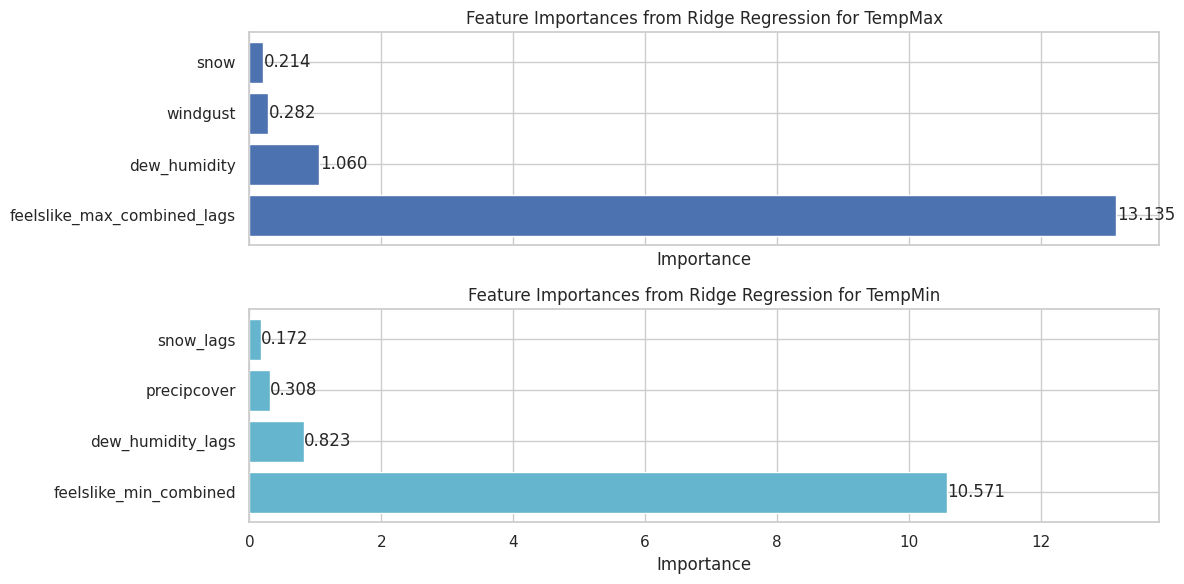

In [1242]:
# Extract and sort feature importances for TempMax
importances_max = abs(ridge_model_max.coef_)
importance_df_max = pd.DataFrame({
    'Feature': X_train_max.columns,
    'Importance': importances_max
}).sort_values(by='Importance', ascending=False)

# Extract and sort feature importances for TempMin
importances_min = abs(ridge_model_min.coef_)
importance_df_min = pd.DataFrame({
    'Feature': X_train_min.columns,
    'Importance': importances_min
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances for TempMax and TempMin
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

# Plot for TempMax
ax1.barh(importance_df_max['Feature'], importance_df_max['Importance'], color=color_pal[0])
ax1.set_title('Feature Importances from Ridge Regression for TempMax')
ax1.set_xlabel('Importance')
for index, value in enumerate(importance_df_max['Importance']):
    ax1.text(value + 0.01, index, f'{value:.3f}', va='center')

# Plot for TempMin
ax2.barh(importance_df_min['Feature'], importance_df_min['Importance'], color=color_pal[9])
ax2.set_title('Feature Importances from Ridge Regression for TempMin')
ax2.set_xlabel('Importance')
for index, value in enumerate(importance_df_min['Importance']):
    ax2.text(value + 0.01, index, f'{value:.3f}', va='center')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Cross-Validation and Validation Set Evaluation
Five-fold cross-validation provides a robust estimate of model performance, while validation set evaluation with metrics such as **R²**, **RMSE**, and **Durbin-Watson** statistics checks the model fit and residual independence.

In [1221]:
# Perform 5-fold cross-validation for TempMax
cv_scores_max = cross_val_score(ridge_model_max, X_train_max_scaled, y_train_max, cv=5, scoring='r2')

# Perform 5-fold cross-validation for TempMin
cv_scores_min = cross_val_score(ridge_model_min, X_train_min_scaled, y_train_min, cv=5, scoring='r2')

# Display cross-validation results
print("\n--- Cross-Validation Results ---")
print(f"TempMax - Mean R²: {cv_scores_max.mean():.4f}, Scores: {cv_scores_max}")
print(f"TempMin - Mean R²: {cv_scores_min.mean():.4f}, Scores: {cv_scores_min}")


--- Cross-Validation Results ---
TempMax - Mean R²: 0.9581, Scores: [0.9633471  0.94551719 0.9648483  0.96338988 0.95358412]
TempMin - Mean R²: 0.9640, Scores: [0.980078   0.92228257 0.9623005  0.98311709 0.97227793]


In [1222]:
# Predict on the validation set for TempMax and TempMin
y_pred_val_max = ridge_model_max.predict(X_val_max_scaled)
y_pred_val_min = ridge_model_min.predict(X_val_min_scaled)

# Calculate performance metrics and residuals for TempMax
r2_val_max = r2_score(y_val_max, y_pred_val_max)
rmse_max = np.sqrt(mean_squared_error(y_val_max, y_pred_val_max))
residuals_max = y_val_max - y_pred_val_max
dw_stat_max = durbin_watson(residuals_max)

# Calculate performance metrics and residuals for TempMin
r2_val_min = r2_score(y_val_min, y_pred_val_min)
rmse_min = np.sqrt(mean_squared_error(y_val_min, y_pred_val_min))
residuals_min = y_val_min - y_pred_val_min
dw_stat_min = durbin_watson(residuals_min)

# Display validation results
print("\n--- Validation Set Results ---")
print(f"TempMax - R²: {r2_val_max:.4f}, RMSE: {rmse_max:.4f}, Durbin-Watson: {dw_stat_max:.4f}")
print(f"TempMin - R²: {r2_val_min:.4f}, RMSE: {rmse_min:.4f}, Durbin-Watson: {dw_stat_min:.4f}")



--- Validation Set Results ---
TempMax - R²: 0.9279, RMSE: 2.0044, Durbin-Watson: 1.8047
TempMin - R²: 0.9348, RMSE: 1.4327, Durbin-Watson: 1.3381


#### Autocorrelation and Heteroscedasticity Checks
We used **ACF** and **PACF** plots to examine residual autocorrelation and **Breusch-Pagan** tests to detect heteroscedasticity, ensuring that model assumptions hold and the predictions are reliable.

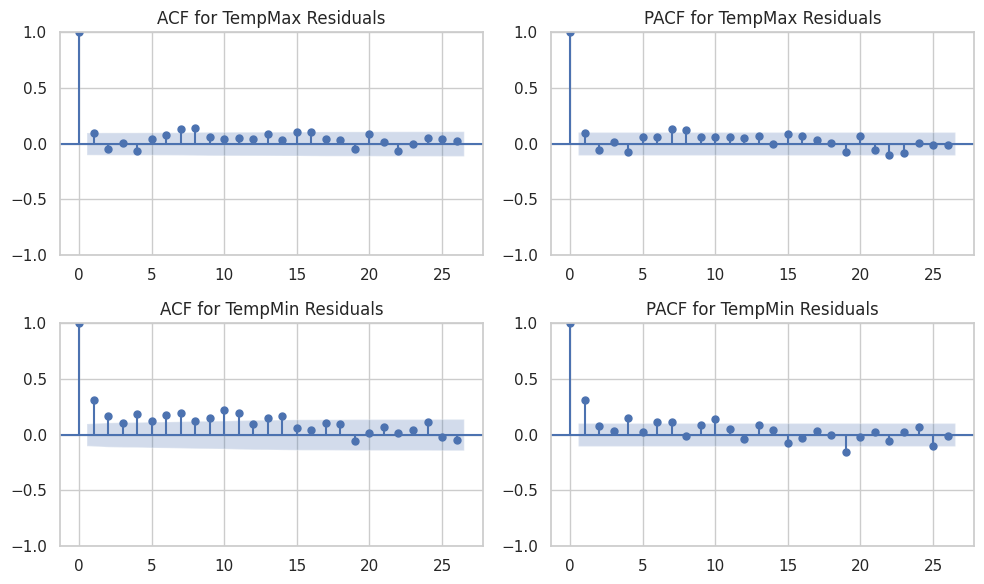

In [1223]:
# Plot ACF and PACF of residuals for TempMax and TempMin
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# ACF for TempMax Residuals
plot_acf(residuals_max, ax=ax[0, 0])
ax[0, 0].set_title('ACF for TempMax Residuals')

# ACF for TempMin Residuals
plot_acf(residuals_min, ax=ax[1, 0])
ax[1, 0].set_title('ACF for TempMin Residuals')

# PACF for TempMax Residuals
plot_pacf(residuals_max, ax=ax[0, 1])
ax[0, 1].set_title('PACF for TempMax Residuals')

# PACF for TempMin Residuals
plot_pacf(residuals_min, ax=ax[1, 1])
ax[1, 1].set_title('PACF for TempMin Residuals')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [1249]:
# Add a constant to the validation set features
X_val_max_scaled_with_const = sm.add_constant(X_val_max_scaled)
X_val_min_scaled_with_const = sm.add_constant(X_val_min_scaled)

# Perform the Breusch-Pagan test on the residuals for TempMax and TempMin
bp_test_max = het_breuschpagan(residuals_max, X_val_max_scaled_with_const)
bp_test_min = het_breuschpagan(residuals_min, X_val_min_scaled_with_const)

# Display Breusch-Pagan test results
labels = ['LM Statistic', 'LM Test p-value', 'F-Statistic', 'F-Test p-value']
print("\n--- Breusch-Pagan Test Results ---")
print('TempMax:')
for label, result in zip(labels, bp_test_max):
    print(f'{label}: {result:.4f}')
print('TempMin:')
for label, result in zip(labels, bp_test_min):
    print(f'{label}: {result:.4f}')

# Calculate fitted values for the validation set
fitted_values_max = ridge_model_max.predict(X_val_max_scaled)
fitted_values_min = ridge_model_min.predict(X_val_min_scaled)



--- Breusch-Pagan Test Results ---
TempMax:
LM Statistic: 10.8428
LM Test p-value: 0.0284
F-Statistic: 2.7528
F-Test p-value: 0.0279
TempMin:
LM Statistic: 70.9524
LM Test p-value: 0.0000
F-Statistic: 21.4397
F-Test p-value: 0.0000


### Performance Metrics
To complement RMSE, we also calculated **Mean Absolute Error (MAE)** and **Adjusted R²** to provide a comprehensive view of the model's predictive accuracy and goodness-of-fit.

In [1225]:
# Calculate MAE for TempMax and TempMin
mae_max = mean_absolute_error(y_val_max, y_pred_val_max)
mae_min = mean_absolute_error(y_val_min, y_pred_val_min)
print(f"TempMax - MAE: {mae_max:.4f}")
print(f"TempMin - MAE: {mae_min:.4f}")

# Calculate Adjusted R² for TempMax and TempMin
n_max, p_max = X_val_max_scaled.shape
n_min, p_min = X_val_min_scaled.shape
adjusted_r2_max = 1 - (1 - r2_val_max) * (n_max - 1) / (n_max - p_max - 1)
adjusted_r2_min = 1 - (1 - r2_val_min) * (n_min - 1) / (n_min - p_min - 1)
print(f"TempMax - Adjusted R²: {adjusted_r2_max:.4f}")
print(f"TempMin - Adjusted R²: {adjusted_r2_min:.4f}")


TempMax - MAE: 1.4911
TempMin - MAE: 1.1073
TempMax - Adjusted R²: 0.9271
TempMin - Adjusted R²: 0.9341


### Visualizing the Results
To better understand the model’s predictions, we visualize the actual vs. predicted values, residuals, and their distribution.
- **Residuals Distribution**: This includes both the histogram of residuals and the Q-Q plot. Ideally, the residuals should follow a normal distribution, as shown in the top row of the reference image. A normal residual distribution suggests that the model errors are random and unbiased.
- **Actual vs. Predicted Values**: This plot shows how closely the predicted values align with the actual values over time. Ideally, the predicted line would follow the actual line closely if not perfectly, indicating that the model is accurately capturing the temperature trends.

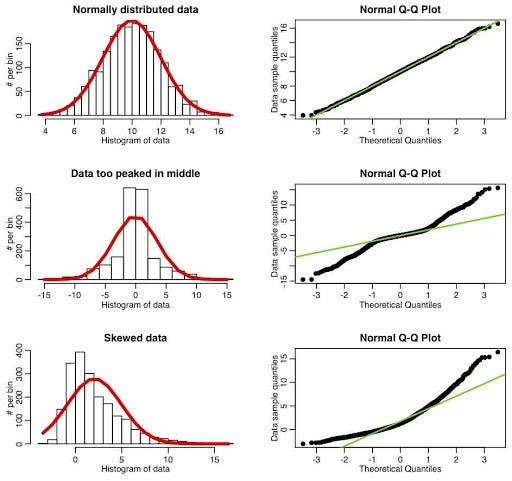

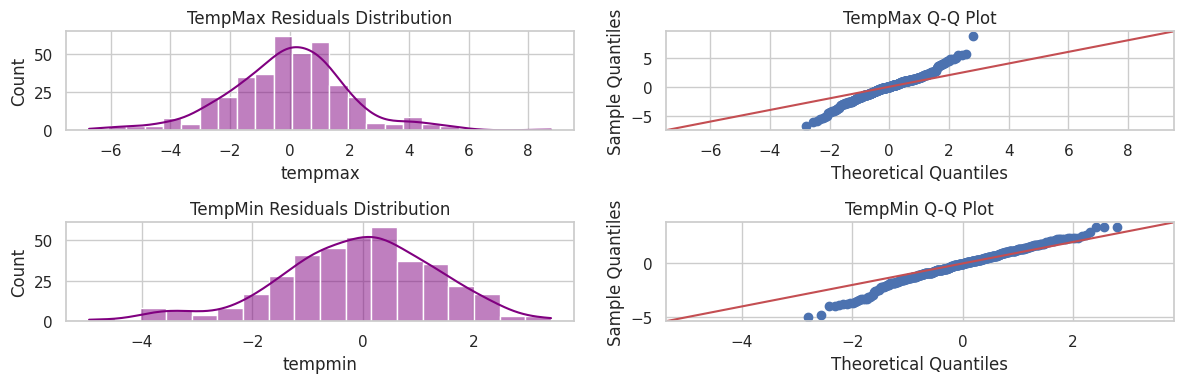

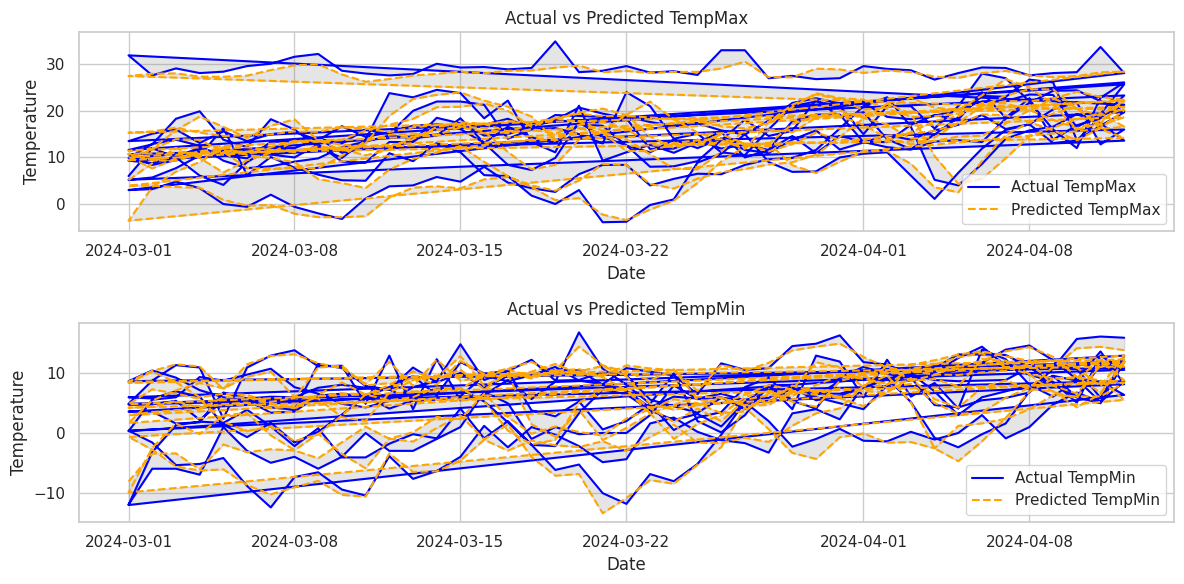

In [1226]:
# Plot Residuals distribution and Q-Q plots
fig, ax = plt.subplots(2, 2, figsize=(12, 4))

# TempMax Residuals
sns.histplot(residuals_max, kde=True, ax=ax[0, 0], color='purple')
ax[0, 0].set_title('TempMax Residuals Distribution')
sm.qqplot(residuals_max, line ='45', ax=ax[0, 1])
ax[0, 1].set_title('TempMax Q-Q Plot')

# TempMin Residuals
sns.histplot(residuals_min, kde=True, ax=ax[1, 0], color='purple')
ax[1, 0].set_title('TempMin Residuals Distribution')
sm.qqplot(residuals_min, line ='45', ax=ax[1, 1])
ax[1, 1].set_title('TempMin Q-Q Plot')

plt.tight_layout()
plt.show()

# Plot Actual vs Predicted values for TempMax and TempMin
plt.figure(figsize=(12, 6))

# TempMax
plt.subplot(2, 1, 1)
plt.plot(y_val_max.index.get_level_values('datetime'), y_val_max, label='Actual TempMax', color='blue')
plt.plot(y_val_max.index.get_level_values('datetime'), y_pred_val_max, label='Predicted TempMax', color='orange', linestyle='--')
plt.fill_between(y_val_max.index.get_level_values('datetime'), y_val_max, y_pred_val_max, color='gray', alpha=0.2)
plt.title('Actual vs Predicted TempMax')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

# TempMin
plt.subplot(2, 1, 2)
plt.plot(y_val_min.index.get_level_values('datetime'), y_val_min, label='Actual TempMin', color='blue')
plt.plot(y_val_min.index.get_level_values('datetime'), y_pred_val_min, label='Predicted TempMin', color='orange', linestyle='--')
plt.fill_between(y_val_min.index.get_level_values('datetime'), y_val_min, y_pred_val_min, color='gray', alpha=0.2)
plt.title('Actual vs Predicted TempMin')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

plt.tight_layout()
plt.show()

## Conclusion

The Ridge Regression models for predicting both `TempMax` and `TempMin` demonstrate strong performance, achieving high R² scores and low RMSE values across both cross-validation and validation datasets. Feature importance analysis highlights the significant influence of key predictors on temperature forecasts. Future steps may involve refining these models further by incorporating additional features or exploring alternative algorithms to capture more complex relationships within the data.

To enhance predictive accuracy, future work should consider integrating more advanced models or techniques that better capture non-linear or temporal dependencies in the data.

**Performance Metrics**

<details>
<summary>Cross-Validation Results</summary>

- **TempMax**
  - **Mean R²**: 0.9581
  - **Scores**: [0.9633, 0.9455, 0.9648, 0.9634, 0.9536]

- **TempMin**
  - **Mean R²**: 0.9640
  - **Scores**: [0.9801, 0.9223, 0.9623, 0.9831, 0.9723]

</details>

<details>
<summary>Validation Set Results</summary>

- **TempMax**
  - **R²**: 0.9279
  - **RMSE**: 2.0044
  - **Durbin-Watson**: 1.8047
  - **MAE**: 1.4911
  - **Adjusted R²**: 0.9271

- **TempMin**
  - **R²**: 0.9348
  - **RMSE**: 1.4327
  - **Durbin-Watson**: 1.3381
  - **MAE**: 1.1073
  - **Adjusted R²**: 0.9341

</details>

<details>
<summary>Breusch-Pagan Test Results</summary>

- **TempMax**
  - **LM Statistic**: 10.8428
  - **LM Test p-value**: 0.0284
  - **F-Statistic**: 2.7528
  - **F-Test p-value**: 0.0279

- **TempMin**
  - **LM Statistic**: 70.9524
  - **LM Test p-value**: 0.0000
  - **F-Statistic**: 21.4397
  - **F-Test p-value**: 0.0000

</details>

<details>
<summary>Interpretation of Results</summary>

- **Cross-Validation Results**: The mean R² scores for both TempMax (0.9581) and TempMin (0.9640) suggest that the models perform well across all folds, indicating a strong generalization ability.

- **Validation Set Results**: The high R² values on the validation set (0.9279 for TempMax and 0.9348 for TempMin) indicate that the models explain a significant portion of the variance in the data. The relatively low RMSE values further confirm the accuracy of these predictions.

- **Durbin-Watson Statistics**: The Durbin-Watson values for TempMax (1.8047) and TempMin (1.3381) indicate some positive autocorrelation in the residuals. This suggests that there might be patterns in the residuals that could be further explored, especially for TempMin.

- **Breusch-Pagan Test Results**: The p-values from the Breusch-Pagan tests indicate heteroscedasticity in both models, more pronounced in the TempMin model. This suggests that there are some variations in the error terms, which could potentially be addressed by model adjustments or transformations.

- **MAE and Adjusted R²**: The MAE values show that the average prediction errors are around 1.5 for TempMax and 1.1 for TempMin. The Adjusted R² values, which account for the number of predictors, confirm that both models are well-fitted.

</details>

Given the strengths and limitations of Ridge Regression, particularly its sensitivity to multicollinearity and assumptions of linearity, the model's performance is robust. However, further refinement could be pursued by exploring transformations, interaction terms, or even combining Ridge Regression with other models to capture more complex relationships and dependencies in the data.


## **Model Evaluation Summary**

### Predicting on the Test Set
Predicting on the test set validates the model's ability to generalize, ensuring robustness and avoiding overfitting. This final step confirms the model's readiness for practical use.

In [1227]:
# Predict TempMax and TempMin using the trained Ridge Regression models
y_pred_test_max = ridge_model_max.predict(X_test_max_scaled)
y_pred_test_min = ridge_model_min.predict(X_test_min_scaled)


### Performance Metrics


In [1228]:
# Calculate R², RMSE, and MAE for TempMax
r2_test_max = r2_score(y_test_max, y_pred_test_max)
rmse_test_max = np.sqrt(mean_squared_error(y_test_max, y_pred_test_max))
mae_test_max = mean_absolute_error(y_test_max, y_pred_test_max)

# Calculate R², RMSE, and MAE for TempMin
r2_test_min = r2_score(y_test_min, y_pred_test_min)
rmse_test_min = np.sqrt(mean_squared_error(y_test_min, y_pred_test_min))
mae_test_min = mean_absolute_error(y_test_min, y_pred_test_min)

# Display test set performance results
print("\n--- Test Set Results ---")
print(f"TempMax - R²: {r2_test_max:.4f}, RMSE: {rmse_test_max:.4f}, MAE: {mae_test_max:.4f}")
print(f"TempMin - R²: {r2_test_min:.4f}, RMSE: {rmse_test_min:.4f}, MAE: {mae_test_min:.4f}")



--- Test Set Results ---
TempMax - R²: 0.9125, RMSE: 1.9905, MAE: 1.5322
TempMin - R²: 0.9465, RMSE: 1.2086, MAE: 0.9563


### Residual Analysis

In [1229]:
# Calculate residuals for TempMax and TempMin
residuals_test_max = y_test_max - y_pred_test_max
residuals_test_min = y_test_min - y_pred_test_min

# Durbin-Watson statistic for TempMax and TempMin to check for autocorrelation in residuals
dw_stat_test_max = durbin_watson(residuals_test_max)
dw_stat_test_min = durbin_watson(residuals_test_min)

# Display Durbin-Watson statistics
print(f"TempMax - Durbin-Watson: {dw_stat_test_max:.4f}")
print(f"TempMin - Durbin-Watson: {dw_stat_test_min:.4f}")


TempMax - Durbin-Watson: 1.6933
TempMin - Durbin-Watson: 1.3167


### Visualizations

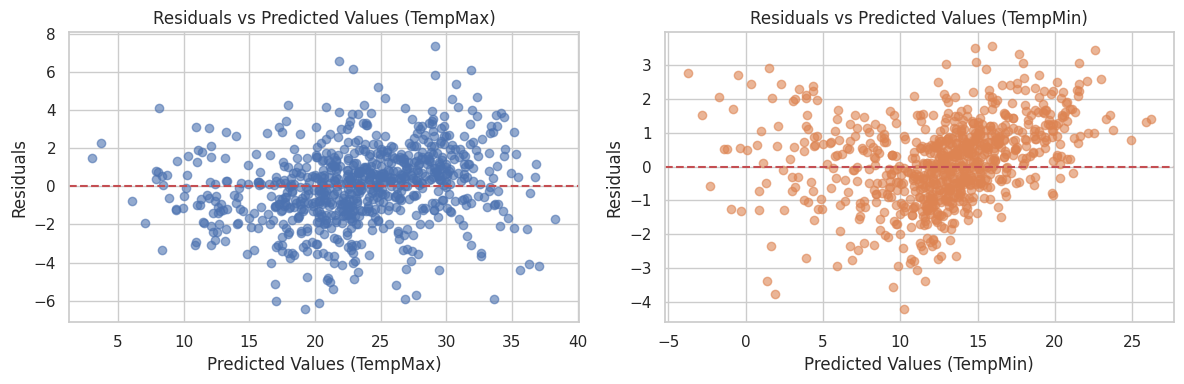

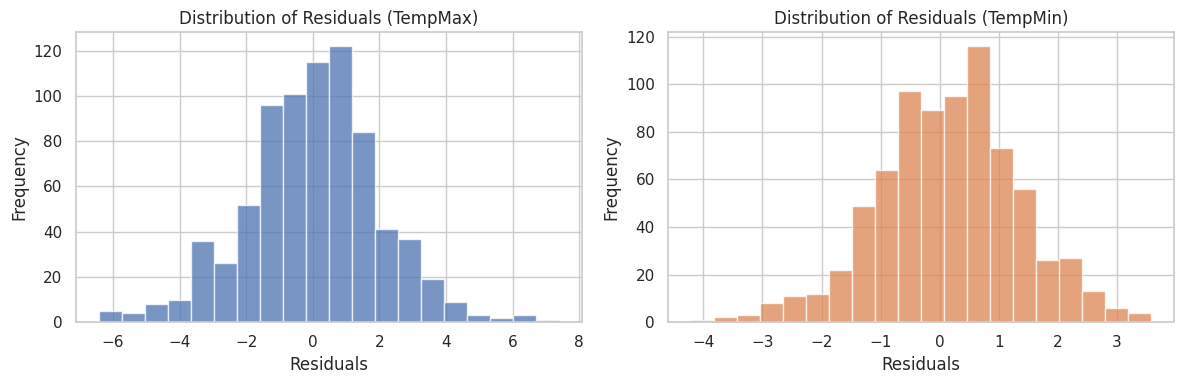

In [1230]:
# Plot residuals vs fitted values for TempMax and TempMin
plt.figure(figsize=(12, 4))

# Plot for TempMax
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test_max, residuals_test_max, color=color_pal[0], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (TempMax)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (TempMax)')
plt.grid(True)

# Plot for TempMin
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test_min, residuals_test_min, color=color_pal[1], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (TempMin)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (TempMin)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the distribution of residuals (histogram)
plt.figure(figsize=(12, 4))

# Histogram for TempMax Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_test_max, bins=20, color=color_pal[0], alpha=0.75)
plt.title('Distribution of Residuals (TempMax)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for TempMin Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_test_min, bins=20, color=color_pal[1], alpha=0.75)
plt.title('Distribution of Residuals (TempMin)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

### Autocorrelation Analysis

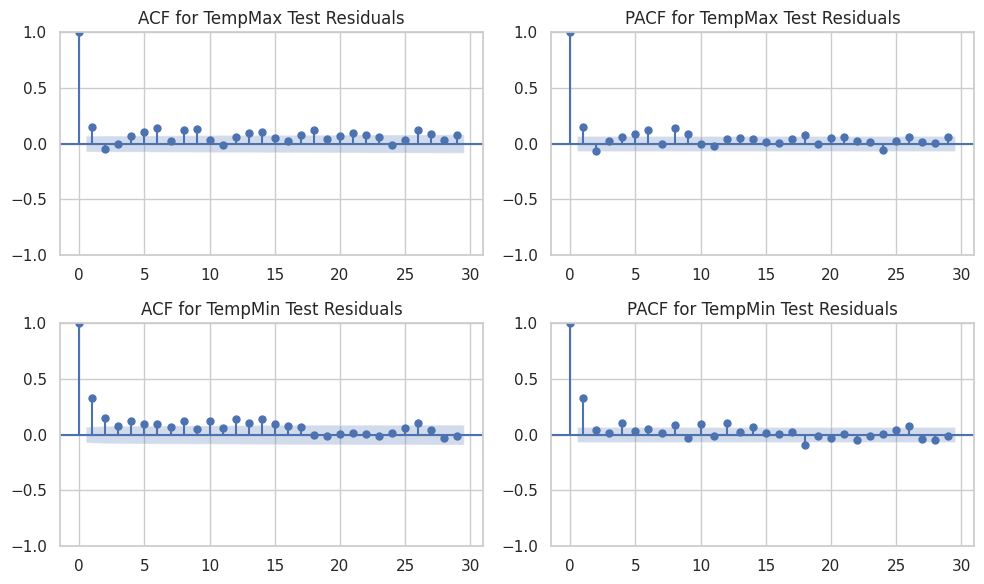

In [1231]:
# Plot ACF and PACF of residuals for TempMax and TempMin
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# ACF for TempMax Residuals
plot_acf(residuals_test_max, ax=ax[0, 0])
ax[0, 0].set_title('ACF for TempMax Test Residuals')

# ACF for TempMin Residuals
plot_acf(residuals_test_min, ax=ax[1, 0])
ax[1, 0].set_title('ACF for TempMin Test Residuals')

# PACF for TempMax Residuals
plot_pacf(residuals_test_max, ax=ax[0, 1])
ax[0, 1].set_title('PACF for TempMax Test Residuals')

# PACF for TempMin Residuals
plot_pacf(residuals_test_min, ax=ax[1, 1])
ax[1, 1].set_title('PACF for TempMin Test Residuals')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### Generating and Storing Predictions
The following code snippet is used to generate and store the predictions of our Ridge Regression models on the test dataset.

This approach consolidates the actual test data and model predictions into a single dataframe, making it easier to compare predicted values with actual values.

In [1232]:
predicted_df = test.copy()
predicted_df['predicted_max'] = y_pred_test_max
predicted_df['predicted_min'] = y_pred_test_min

In [1254]:
predicted_df = predicted_df[['tempmax', 'predicted_max', 'tempmin', 'predicted_min']].copy()
predicted_df.head()

tempmax  predicted_max  tempmin  predicted_min
location datetime                                                  
Beijing  2024-04-13     27.0      25.413834     13.0      13.504959
         2024-04-14     19.1      23.016299     15.0      12.964787
         2024-04-15     24.3      24.183815     13.1      13.450338
         2024-04-16     27.0      27.533346      8.0       9.598367
         2024-04-17     28.0      26.466229      7.0       9.009679

In [1250]:
# For TempMax
mae_test_max = mean_absolute_error(y_test_max, y_pred_test_max)
mse_test_max = mean_squared_error(y_test_max, y_pred_test_max)
rmse_test_max = np.sqrt(mse_test_max)
r2_test_max = r2_score(y_test_max, y_pred_test_max)

# For TempMin
mae_test_min = mean_absolute_error(y_test_min, y_pred_test_min)
mse_test_min = mean_squared_error(y_test_min, y_pred_test_min)
rmse_test_min = np.sqrt(mse_test_min)
r2_test_min = r2_score(y_test_min, y_pred_test_min)

# Print results
print("Test Set Performance Metrics:")
print(f"TempMax - MAE: {mae_test_max:.4f}")
print(f"TempMax - MSE: {mse_test_max:.4f}")
print(f"TempMax - RMSE: {rmse_test_max:.4f}")
print(f"TempMax - R²: {r2_test_max:.4f}")

print(f"TempMin - MAE: {mae_test_min:.4f}")
print(f"TempMin - MSE: {mse_test_min:.4f}")
print(f"TempMin - RMSE: {rmse_test_min:.4f}")
print(f"TempMin - R²: {r2_test_min:.4f}")


Test Set Performance Metrics:
TempMax - MAE: 1.5322
TempMax - MSE: 3.9619
TempMax - RMSE: 1.9905
TempMax - R²: 0.9125
TempMin - MAE: 0.9563
TempMin - MSE: 1.4608
TempMin - RMSE: 1.2086
TempMin - R²: 0.9465


### Visualizing predicted values
We interpret the results as presented in the attached image:

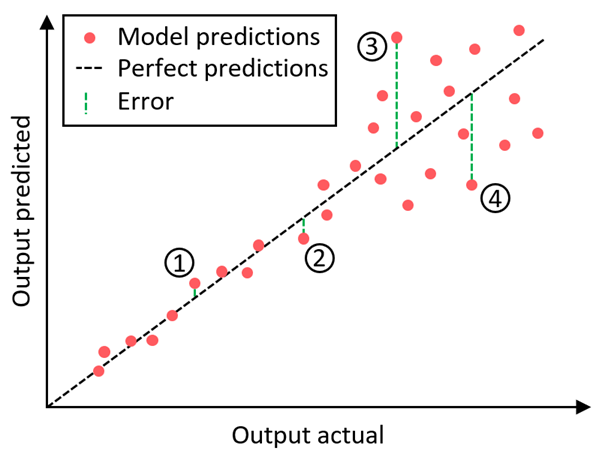

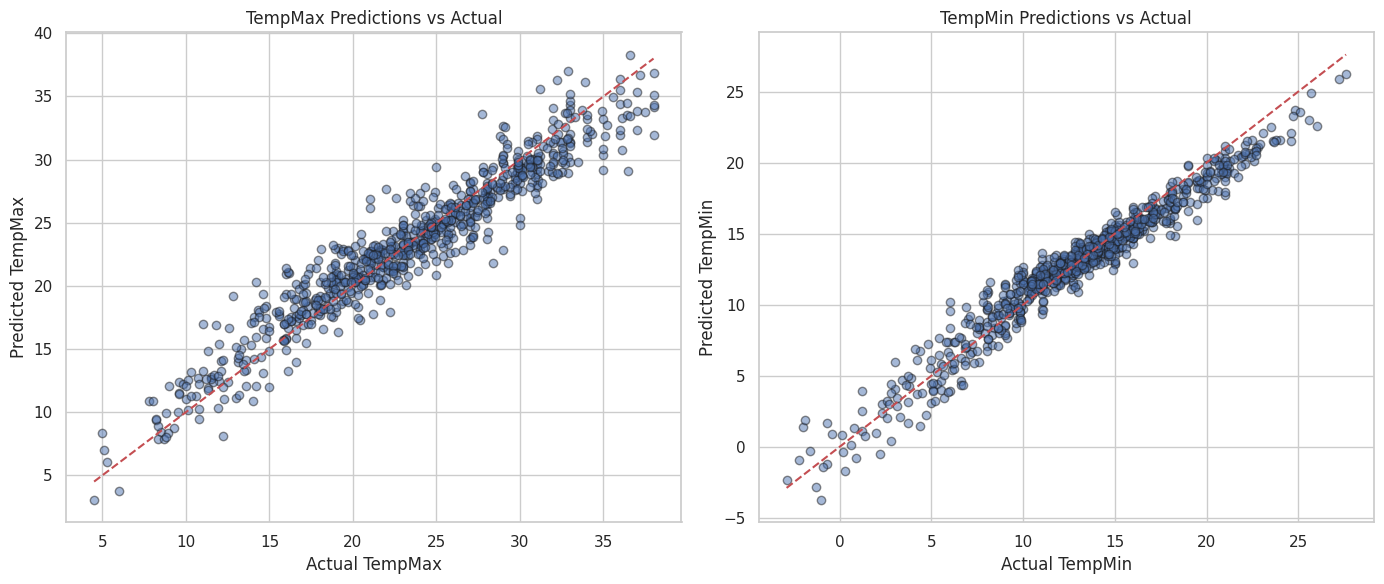

In [1235]:
plt.figure(figsize=(14, 6))

# Scatter plot for TempMax
plt.subplot(1, 2, 1)
plt.scatter(y_test_max, y_pred_test_max, alpha=0.5, edgecolors='k')
plt.plot([y_test_max.min(), y_test_max.max()], [y_test_max.min(), y_test_max.max()], 'r--')
plt.xlabel('Actual TempMax')
plt.ylabel('Predicted TempMax')
plt.title('TempMax Predictions vs Actual')

# Scatter plot for TempMin
plt.subplot(1, 2, 2)
plt.scatter(y_test_min, y_pred_test_min, alpha=0.5, edgecolors='k')
plt.plot([y_test_min.min(), y_test_min.max()], [y_test_min.min(), y_test_min.max()], 'r--')
plt.xlabel('Actual TempMin')
plt.ylabel('Predicted TempMin')
plt.title('TempMin Predictions vs Actual')

plt.tight_layout()
plt.show()


## Key Takeaways
- **Ridge Regression** shows strong performance with high R² and low RMSE values, confirming effective temperature prediction.
- **Residual Analysis** reveals some autocorrelation, suggesting potential for model refinement.
- **Visualizations** demonstrate that residuals are fairly normally distributed, aligning with Ridge Regression’s strengths in handling multicollinearity and regularization.

This approach ensures that the Ridge Regression model is well-evaluated and ready for practical applications, with clear insights into its strengths and areas for improvement.

**In summary**, the models show strong performance and are generally acceptable for production. However, addressing the detected heteroskedasticity and autocorrelation could further enhance their robustness and reliability.